In [1]:
import pandas as pd
from tqdm import tqdm
import os
import json

In [2]:
tqdm.pandas()

In [3]:
base_path = "/mnt/disks/data/fma"

In [4]:
metadata_path = os.path.join(base_path,"fma_metadata")

In [5]:
dataset_path =  os.path.join(base_path,"fma_large")

In [6]:
# first, we need to import our essentia module. It is aptly named 'essentia'!
import essentia

# there are two operating modes in essentia which (mostly) have the same algorithms
# they are accessible via two submodules:
import essentia.standard
import essentia.streaming

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [7]:
df_tracks = pd.read_csv(os.path.join(metadata_path,"tracks_genres_id_full.csv"))

In [8]:
# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename=df_tracks.iloc[1].file_path)

# and then we actually perform the loading:
audio = loader()

In [9]:
# This is how the audio we want to process sounds like
import IPython
IPython.display.Audio(df_tracks.iloc[1].file_path)

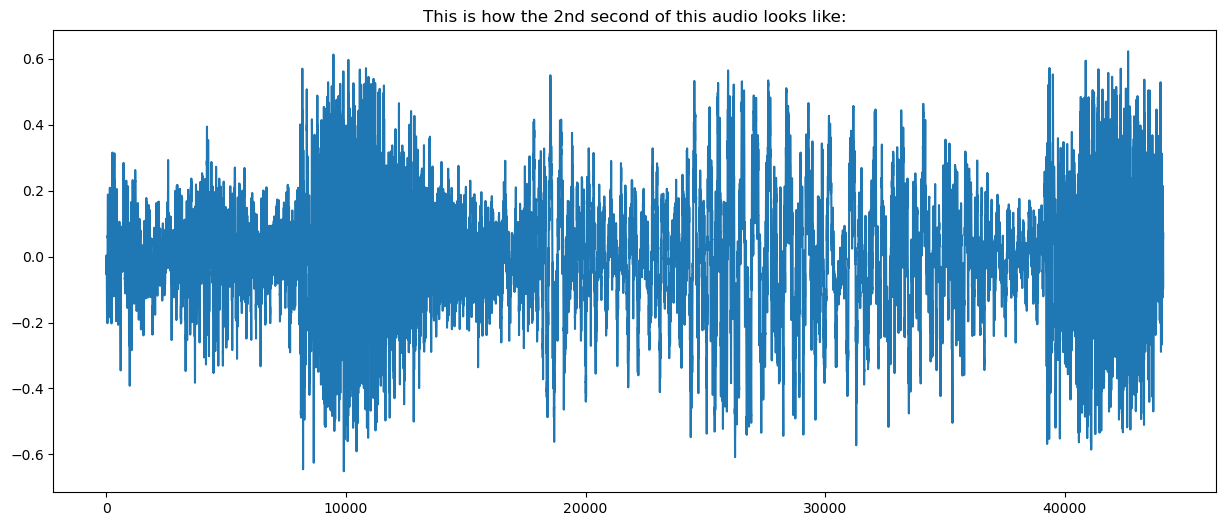

In [10]:
# pylab contains the plot() function, as well as figure, etc... (same names as Matlab)
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6) # set plot sizes to something larger than default

plot(audio[1*44100:2*44100])
plt.title("This is how the 2nd second of this audio looks like:")
show()

In [11]:
from essentia.standard import *
w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
mfcc = MFCC()

[   INFO   ] TriangularBands: input spectrum size (513) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.


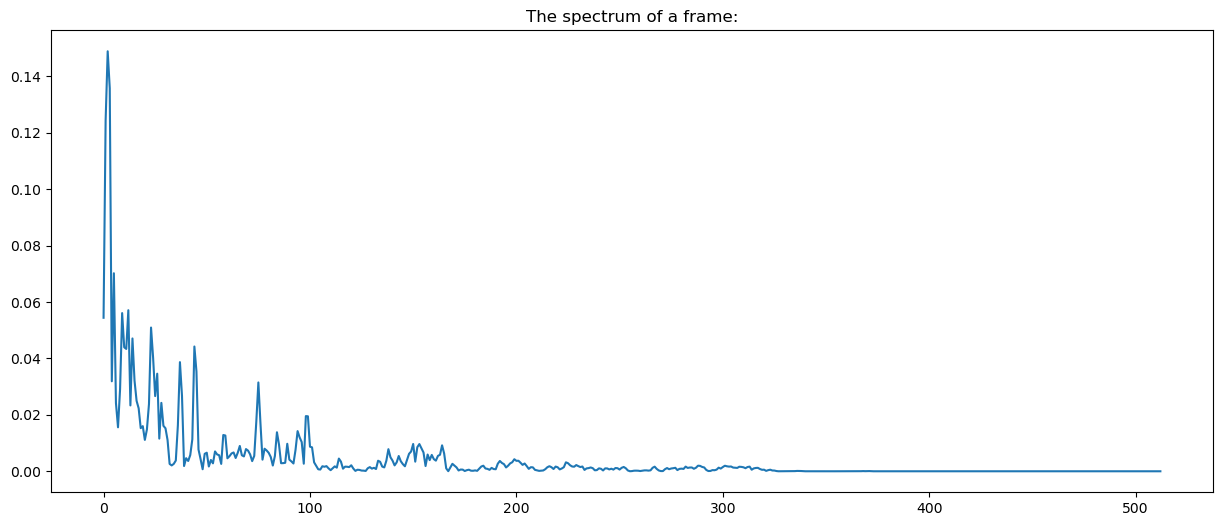

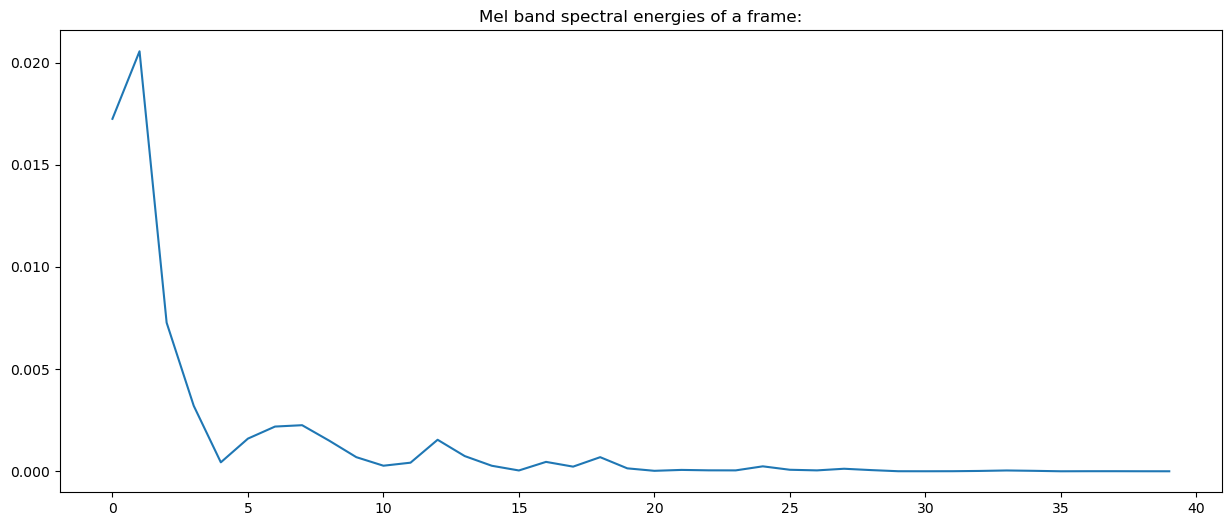

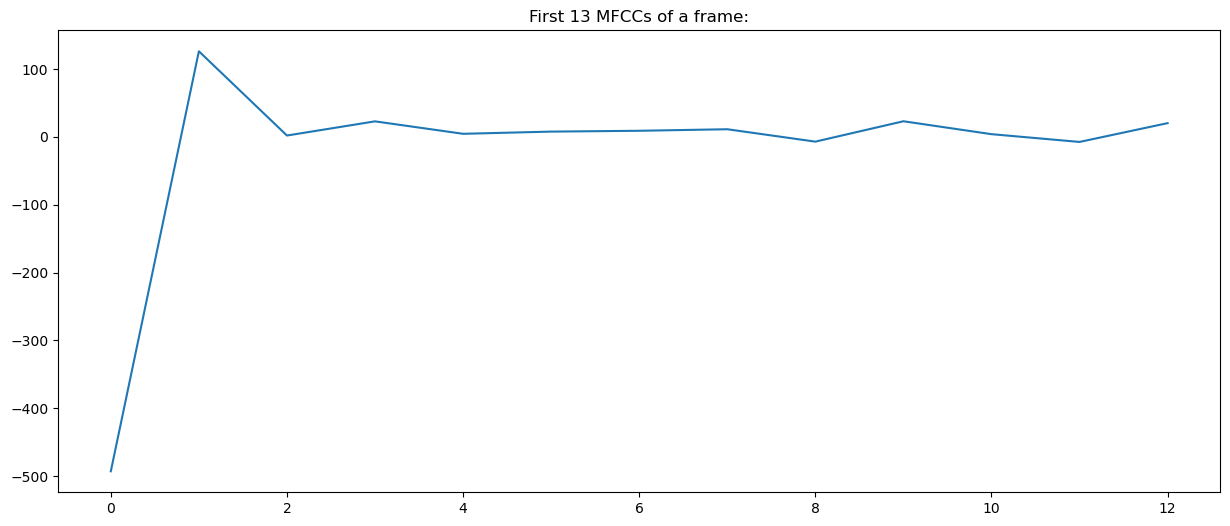

In [12]:
frame = audio[6*44100 : 6*44100 + 1024]
spec = spectrum(w(frame))
mfcc_bands, mfcc_coeffs = mfcc(spec)

plot(spec)
plt.title("The spectrum of a frame:")
show()

plot(mfcc_bands)
plt.title("Mel band spectral energies of a frame:")
show()

plot(mfcc_coeffs)
plt.title("First 13 MFCCs of a frame:")
show()

In [13]:
import librosa

def preprocess_file_librosa(filename,num_segment=10,n_fft=2048,sample_rate=22050,hop_legth=512,n_mfcc=40):
    
    samples_per_segment = int(sample_rate*30/num_segment)
   
    y,sr = librosa.load(filename,sr=sample_rate)

    for n in range(num_segment):
        mfcc = librosa.feature.mfcc(y[samples_per_segment*n:samples_per_segment*(n+1)],
                                    sample_rate,
                                    n_mfcc,
                                    n_fft,
                                    hop_legth)
        break
    
        
    
    

## Extraindo com essentia


In [14]:
import essentia
import essentia.standard as es
# Write the aggregated features into a temporary directory.



In [15]:
import os
def preprocess_file_essentia(filename,num_segment=10,n_fft=2048,sample_rate=22050,hop_legth=512,n_mfcc=40):
    try:
        # Compute all features.
        # Aggregate 'mean' and 'stdev' statistics for all low-level, rhythm, and tonal frame features.
        features, features_frames = es.MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                                      rhythmStats=['mean', 'stdev'],
                                                      tonalStats=['mean', 'stdev'])(filename)

        # See all feature names in the pool in a sorted order
        #print(sorted(features.descriptorNames()))
        feature_file_name = filename.replace('fma_large','fma_large_features').replace('mp3','sig')

        # Create dir
        file_dir = '/'.join(feature_file_name.split('/')[:-1])


        # checking if the directory demo_folder2 
        # exist or not.
        if not os.path.isdir(file_dir):

            # if the demo_folder2 directory is 
            # not present then create it.
            os.makedirs(file_dir)
        es.YamlOutput(filename=feature_file_name, format="json")(features)
    except:
        feature_file_name = "CORRUPTED"
    return feature_file_name

In [16]:
preprocess_file_essentia(df_tracks.iloc[0].file_path)

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


'/mnt/disks/data/fma/fma_large_features/000/000002.json'

In [ ]:
#df_tracks['feature_file_path'] = df_tracks.file_path.progress_apply(lambda x: preprocess_file_essentia(x))

  0%|          | 2/106574 [00:01<29:17:11,  1.01it/s][   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
  0%|          | 3/106574 [00:03<41:49:26,  1.41s/it][   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done
  0%|          | 4/106574 [00:05<48:24:20,  1.64s

In [18]:
df_tracks['feature_file_path'] = df_tracks.file_path.progress_apply(lambda x: x.replace('fma_large','fma_large_sig').replace('mp3','sig'))

100%|██████████| 106574/106574 [00:00<00:00, 678159.00it/s]


In [19]:
#df_tracks['feature_file_path'] = df_tracks.file_path.progress_apply(lambda x: preprocess_file_essentia(x))

In [20]:
df_tracks.to_csv(os.path.join(metadata_path,"tracks_genres_id_full_features.csv"))